# HW03: Embeddings

In [1]:
# Import Libraries
import os
import nltk
import csv
import string
import glob
import numpy as np
import pandas as pd

#from gensim.parsing.porter import PorterStemmer
#from gensim.parsing.preprocessing import remove_stopwords
#from gensim.utils import simple_preprocess
from gensim import corpora
from gensim import models
from gensim import similarities
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

## Simpsons Dataset

### Import training data

In [2]:
# Import data
simpsons_docs = []

# Open and read file
with open('./data/simpsons/X_train.csv', 'r') as read_obj:
    for row in csv.reader(read_obj):
        simpsons_docs.append(row)
        
# Glimpse at training docs
for i in range(0,5):
    print(simpsons_docs[i])

['lisa', 'll', 'do', 'the', 'dishes', 'when', 'pick', 'it', 'out', 'of', 'the', 'chore', 'hat', 'and', 'it', 'not', 'practice', 'see', 'there', 'it', 'is', 'but', 'that', 'was', 'practice', 'the', 'system', 'works']
['don', 'worry', 've', 'got', 'man', 'on', 'the', 'perimeter']
['snowball']
['oh', 'yeah', 'you', 'were', 'way', 'off']
['oh', 'it', 'beautiful', 'oh', 'oh', 'let', 'put', 'bart', 'beautiful', 'drawing', 'up', 'on', 'the', 'fridge']


### Word2Vec Embeddings

In [3]:
# Define Word2Vec Embeddings
simpsons_w2v_model_125 = models.Word2Vec(simpsons_docs, size=125, window=5, min_count=2, workers=10)
simpsons_w2v_model_25 = models.Word2Vec(simpsons_docs, size=25, window=5, min_count=2, workers=10)
simpsons_w2v_model_5 = models.Word2Vec(simpsons_docs, size=5, window=5, min_count=2, workers=10)

# Train Word2Vec Embeddings
simpsons_w2v_model_125.train(simpsons_docs, total_examples=len(simpsons_docs), epochs=10)
simpsons_w2v_model_25.train(simpsons_docs, total_examples=len(simpsons_docs), epochs=10)
simpsons_w2v_model_5.train(simpsons_docs, total_examples=len(simpsons_docs), epochs=10)

(3001638, 4012300)

### 2D Plots

In [4]:
def plot_similar_words(word, model):
    
    # Retrieve similar words
    most_similar = model.wv.most_similar(word)
    
    similar_words = [word]
    for w in most_similar:
        similar_words.append(w[0])
    
    # Create PCA object with 2 components
    pca = PCA(n_components=2)
    
    # Extract embeddings from model
    vocab = list(model.wv.vocab)
    X = model[vocab]
    
    # Fit PCA with all embeddings vocab
    pca.fit(X)
    
    # Transform similar words
    X_pca = pca.transform(model[similar_words])
    
    # Plot
    df = pd.DataFrame(X_pca, index=similar_words, columns=['x', 'y'])
    
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1, 1, 1)
    plt.xlabel('$x_1$', fontsize=15)
    plt.ylabel('$x_2$', fontsize=15)
    plt.title('Most similar words to {}'.format(word), fontsize=20)
    plt.grid(True)
    plt.xlim([-6,6])
    plt.ylim([-4,4])

    ax.scatter(df['x'], df['y'], s=200, c='b', alpha=0.25)
    ax.scatter(df['x'][0], df['y'][0], s=200, c='r', alpha=0.25)
    for word, pos in df.iterrows():
        ax.annotate(word, pos, fontsize=12)
    

C:\Users\CESAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
C:\Users\CESAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


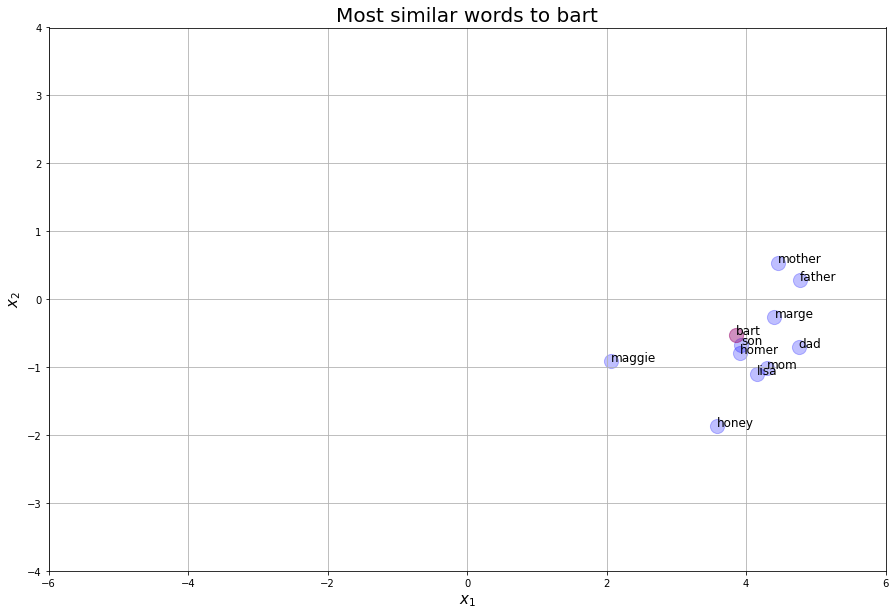

In [5]:
plot_similar_words('bart', simpsons_w2v_model_25)

### Relations